<a href="https://colab.research.google.com/github/AaMNAHZaAFAR/Stock-Market-Prediction/blob/main/stockprediction_with_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
pip install dash plotly tensorflow pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 6.5 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')  # Suppresses warning messages for cleaner output
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices, along with mathematical functions
import pandas as pd  # Offers data structures and data analysis tools for handling structured data
import matplotlib.pyplot as plt  # Core plotting library for creating static, animated, and interactive visualizations in Python
import seaborn as sns  # Builds on Matplotlib to provide a high-level interface for drawing attractive statistical graphics

from sklearn.preprocessing import MinMaxScaler  # Scales and transforms data to a given range, typically between 0 and 1

# Import the LinearSegmentedColormap class from matplotlib.colors to create custom color maps for plotting
from matplotlib.colors import LinearSegmentedColormap

# Import the seasonal_decompose function from statsmodels.tsa.seasonal to decompose time series data into trend, seasonal, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose

# Import the train_test_split function from scikit-learn for splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split

# Import mean_squared_error and r2_score functions from scikit-learn for evaluating model performance
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential  # Import the Sequential model class
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout  # Import various layers for the neural network
from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer

# Importing pickle for loading or saving serialized Python objects
import pickle

import dash # Importing the Dash library for building web applications
from dash import dcc, html # Importing components from Dash for creating interactive dashboards
from dash.dependencies import Input, Output # Importing Input and Output from Dash for handling user interactions
import plotly.graph_objs as go # Importing plotly.graph_objs to create visualizations and graphs
from tensorflow.keras.models import load_model # Importing load_model from TensorFlow Keras to load a pre-trained model




**Install and Configure Kaggle API in Colab**

In [ ]:
# Install Kaggle API
!pip install kaggle

# Create a directory for Kaggle configuration
!mkdir -p ~/.kaggle


**Loading the Dataset**

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d dgawlik/nyse

# Unzip the downloaded dataset
!unzip nyse.zip -d nyse_data


Dataset URL: https://www.kaggle.com/datasets/dgawlik/nyse
License(s): CC0-1.0
 85% 26.0M/30.7M [00:00<00:00, 73.5MB/s]
100% 30.7M/30.7M [00:00<00:00, 76.3MB/s]
Archive:  nyse.zip
  inflating: nyse_data/fundamentals.csv  
  inflating: nyse_data/prices-split-adjusted.csv  
  inflating: nyse_data/prices.csv    
  inflating: nyse_data/securities.csv  


In [ ]:
# Load the dataset into a DataFrame, parsing the 'date' column as datetime and setting it as the index
prices_split_adjusted = pd.read_csv('nyse_data/prices-split-adjusted.csv',index_col='date', parse_dates=['date'])
prices_split_adjusted.head()
#prices_split_adjusted.info()
#prices_split_adjusted.describe()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


**Data Cleaning**

In [ ]:
# Count the number of entries for each symbol
symbol_counts = prices_split_adjusted['symbol'].value_counts()
symbol_counts

,count
symbol,
KSU,1762
NOC,1762
ORCL,1762
OMC,1762
OKE,1762
...,...
KHC,378
HPE,304
CSRA,284


In [ ]:
# Identify symbols with fewer than 1762 entries
omit_symbols = symbol_counts[symbol_counts < 1762].index

# Filter out rows with symbols that have fewer than 1762 entries
prices_split_adjusted = prices_split_adjusted[~prices_split_adjusted['symbol'].isin(omit_symbols)]
prices_split_adjusted.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,A,22.453504,22.389128,22.267525,22.625180,3815500.0
2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0
2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900.0


In [ ]:
# Find the top 5 stocks by the number of entries
top_5_stocks = prices_split_adjusted['symbol'].value_counts().head(5)

# Print the top 5 stocks and their number of entries
print("Top 5 stocks by the number of entries:")
print(top_5_stocks)


Top 5 stocks by the number of entries:
symbol
A      1762
NKE    1762
OMC    1762
OKE    1762
O      1762
Name: count, dtype: int64


In [ ]:
# Find the top 5 stocks by the number of entries
top_5_stocks = prices_split_adjusted['symbol'].value_counts().head(5).index

# Display descriptive statistics for each of the top 10 stocks
for stock_name in top_5_stocks:
    stock = prices_split_adjusted[prices_split_adjusted['symbol'] == stock_name]
    print(f"Descriptive statistics for {stock_name}:")
    print(stock.describe())
    print("\n")

Descriptive statistics for A:
              open        close          low         high        volume
count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
mean     34.065290    34.080221    33.714101    34.414842  3.927589e+06
std       7.438918     7.439467     7.436754     7.446296  2.384677e+06
min      19.334765    19.291845    19.084406    19.706724  5.880000e+05
25%      27.703863    27.687768    27.421316    28.074034  2.297950e+06
50%      34.215157    34.332382    33.844778    34.651903  3.398250e+06
75%      40.559486    40.559486    40.177918    40.885194  4.890125e+06
max      48.630001    48.439999    48.119999    48.630001  2.536860e+07


Descriptive statistics for NKE:
              open        close          low         high        volume
count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
mean     35.684265    35.690609    35.377259    35.993046  9.502834e+06
std      14.798744    14.779681    14.660918    14.908951  5.590828e+06


**Exploratory Data Analysis**

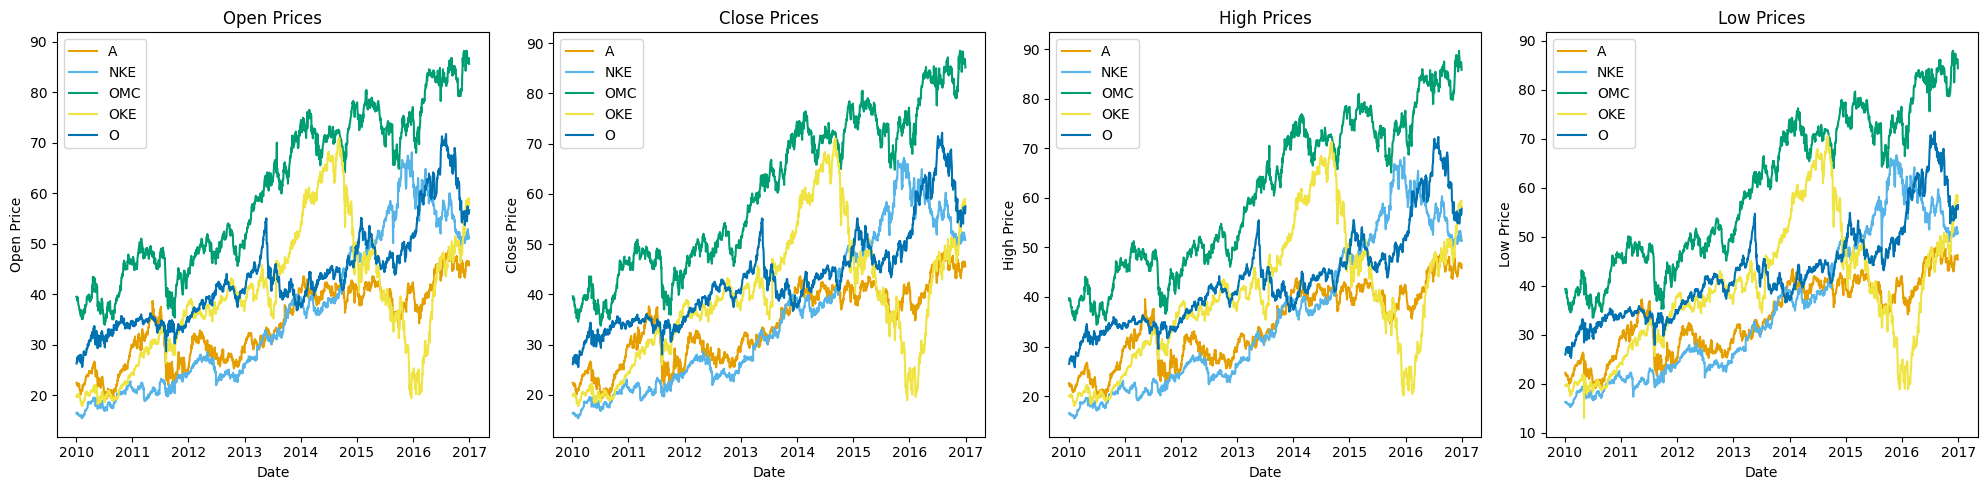

In [ ]:
# Function to plot trends of top 5 stocks metrics in a single line
def plot_stock_metrics_in_line(data, stocks, metrics):
    num_metrics = len(metrics)  # Get the number of metrics to be plotted
    fig, axs = plt.subplots(1, num_metrics, figsize=(20, 5))  # Create subplots for each metric, arranged in a single row

    # Color-blind friendly palette (Okabe & Ito)
    color_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2']  # Orange, Sky Blue, Bluish Green, Yellow, Blue

    for i, metric in enumerate(metrics):  # Iterate over each metric
        for j, stock_name in enumerate(stocks):  # Iterate over each stock symbol
            stock_data = data[data['symbol'] == stock_name]  # Filter data for the current stock symbol
            axs[i].plot(stock_data.index, stock_data[metric], label=stock_name, color=color_palette[j])  # Plot the metric data for the current stock
        axs[i].set_title(f'{metric.capitalize()} Prices')  # Set the title for the subplot
        axs[i].set_xlabel('Date')  # Set the x-axis label
        axs[i].set_ylabel(f'{metric.capitalize()} Price')  # Set the y-axis label
        axs[i].legend(loc='best')  # Add a legend to the subplot

    plt.tight_layout()  # Adjust the layout for better fit
    plt.show()  # Display the plot

# Plot open, close, high, and low for top 5 stocks in a single line
metrics = ['open', 'close', 'high', 'low']  # Define the metrics to be plotted
plot_stock_metrics_in_line(prices_split_adjusted, top_5_stocks, metrics)  # Call the function with the dataset, top 5 stocks, and metrics


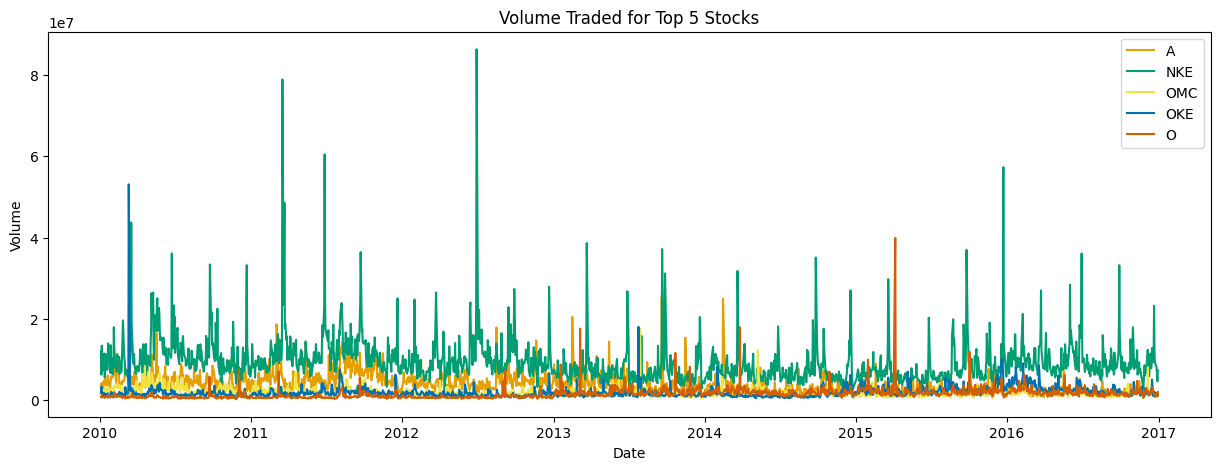

In [ ]:
# Volume Analysis with New Colorblind-Friendly Palette
def plot_volume_analysis(data, stocks):
    plt.figure(figsize=(15, 5))  # Initialize the figure with specified dimensions

    # New Color-blind friendly palette
    color_palette = ['#E69F00', '#009E73', '#F0E442', '#0072B2', '#D55E00']  # Orange, Bluish Green, Yellow, Blue, Vermilion

    for i, stock_name in enumerate(stocks):  # Iterate over each stock symbol with its index
        stock_data = data[data['symbol'] == stock_name]  # Filter data for the current stock symbol
        plt.plot(stock_data.index, stock_data['volume'], label=stock_name, color=color_palette[i])  # Plot the volume data for the current stock

    plt.title('Volume Traded for Top 5 Stocks')  # Set plot title
    plt.xlabel('Date')  # Set x-axis label
    plt.ylabel('Volume')  # Set y-axis label
    plt.legend(loc='best')  # Add legend to the plot
    plt.show()  # Show the plot

# Execute the function with the dataset and top 5 stocks
plot_volume_analysis(prices_split_adjusted, top_5_stocks)


In [ ]:
# Number of data points for 'open' and 'close' prices
n_open = len(prices_split_adjusted['open'])
n_close = len(prices_split_adjusted['close'])

# Calculate number of bins using Sturges' formula
bins_sturges_open = int(1 + np.log2(n_open))
bins_sturges_close = int(1 + np.log2(n_close))

print(f"Sturges' Formula for Opening Prices: Number of bins = {bins_sturges_open}")
print(f"Sturges' Formula for Closing Prices: Number of bins = {bins_sturges_close}")


Sturges' Formula for Opening Prices: Number of bins = 20
Sturges' Formula for Closing Prices: Number of bins = 20


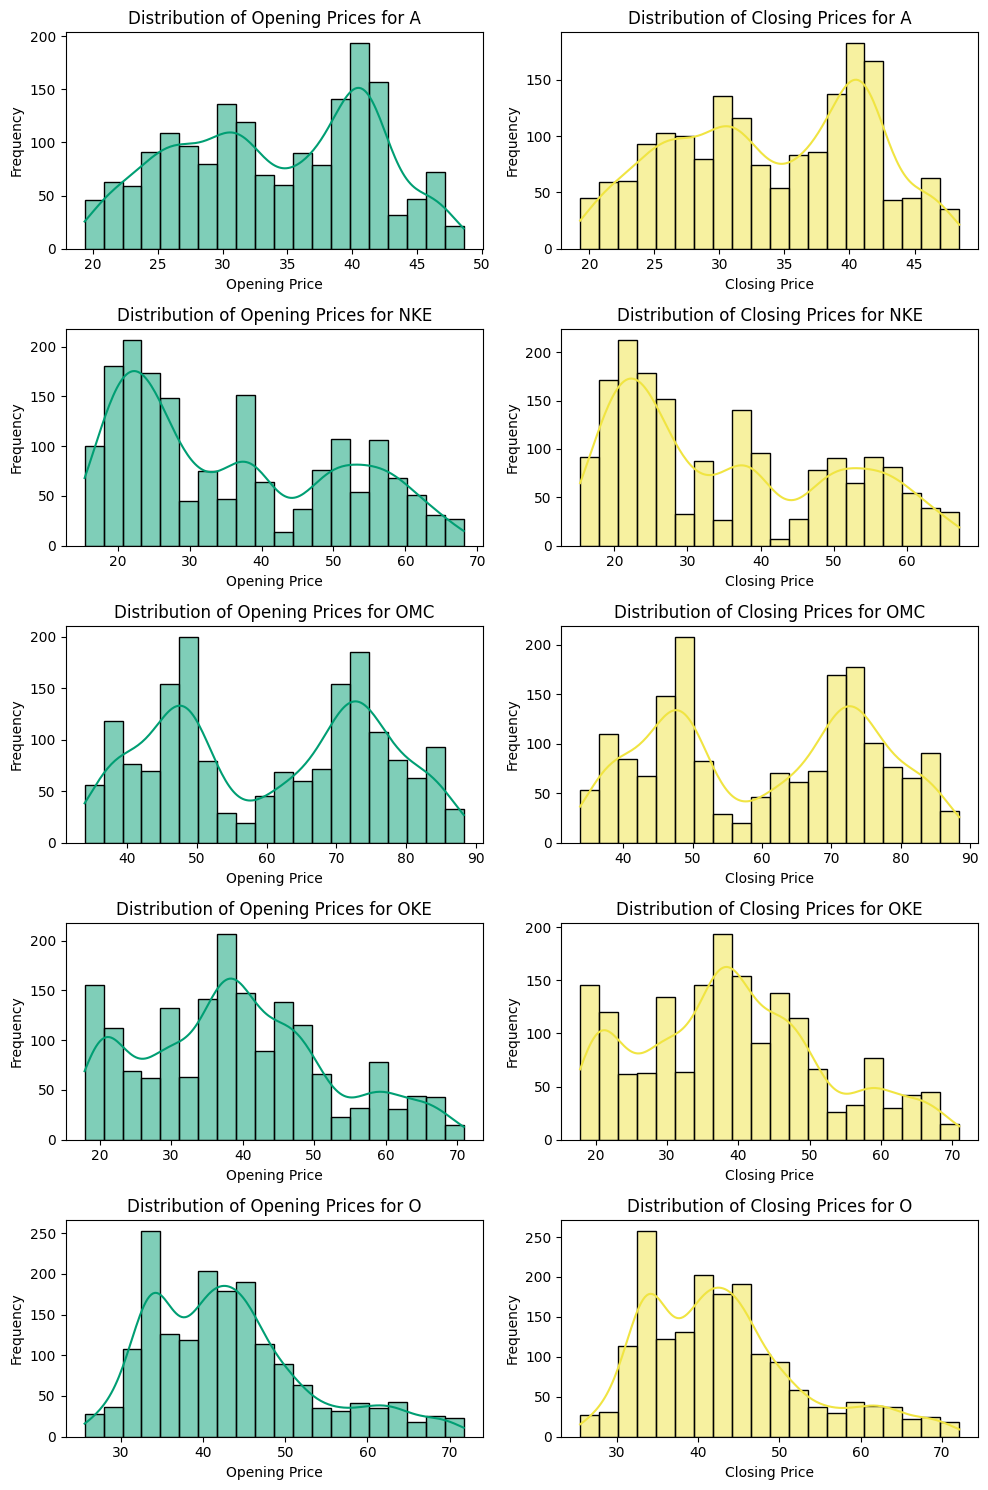

In [ ]:
# Distribution of Stock Prices for Open and Close
def plot_distribution(data, stocks):
    # Create a grid of subplots with a number of rows equal to the number of stocks and 2 columns
    fig, axs = plt.subplots(len(stocks), 2, figsize=(10, 15))

    # Use a color-blind friendly palette
    color_palette = ['#009E73', '#F0E442']

    # Loop over each stock symbol and its index
    for i, stock_name in enumerate(stocks):
        stock_data = data[data['symbol'] == stock_name] # Filter the data for the current stock symbol

        # Plot the distribution of opening prices for the current stock
        sns.histplot(stock_data['open'], kde=True, bins=20, ax=axs[i, 0], color=color_palette[0])
        axs[i, 0].set_title(f'Distribution of Opening Prices for {stock_name}')  # Set the title for the subplot
        axs[i, 0].set_xlabel('Opening Price')  # Set the x-axis label
        axs[i, 0].set_ylabel('Frequency')  # Set the y-axis label

        # Plot the distribution of closing prices for the current stock
        sns.histplot(stock_data['close'], kde=True, bins=20, ax=axs[i, 1], color=color_palette[1])
        axs[i, 1].set_title(f'Distribution of Closing Prices for {stock_name}')  # Set the title for the subplot
        axs[i, 1].set_xlabel('Closing Price')  # Set the x-axis label
        axs[i, 1].set_ylabel('Frequency')  # Set the y-axis label

    plt.tight_layout()  # Adjust subplots to fit into the figure area
    plt.show()  # Display the plot

# Execute the function with the dataset and top 5 stocks
plot_distribution(prices_split_adjusted, top_5_stocks)


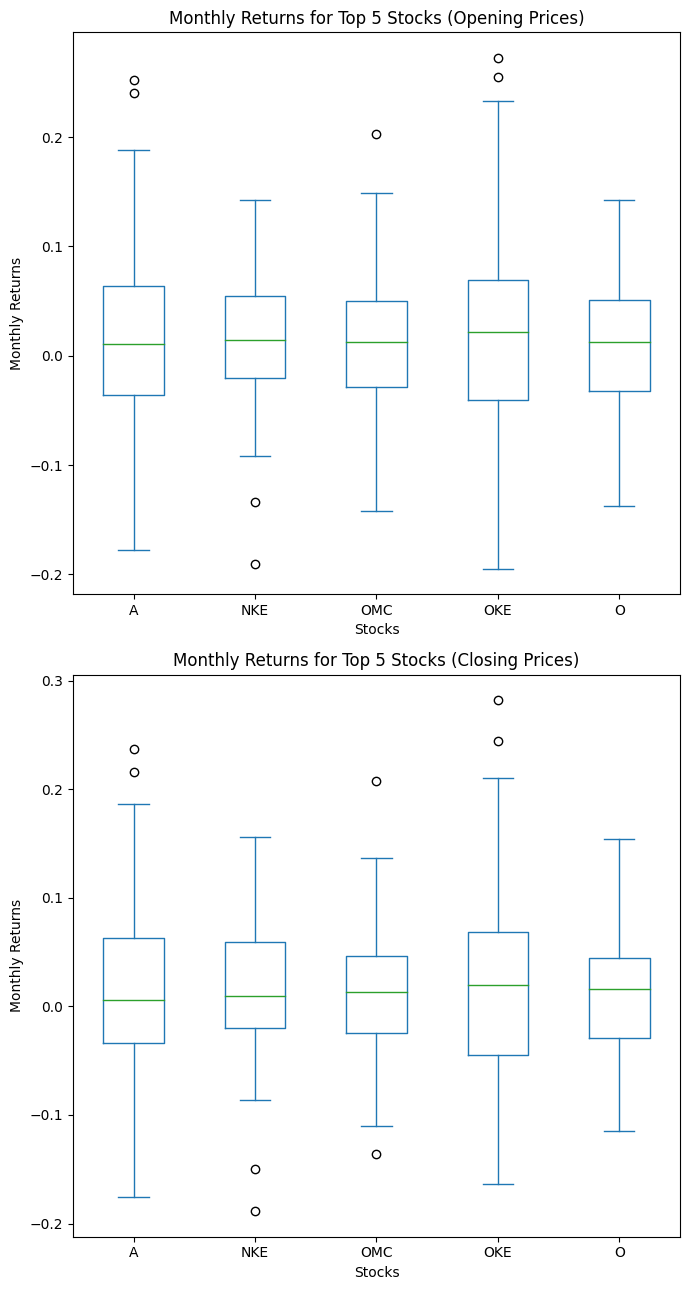

In [ ]:
# Monthly Returns Analysis for Open and Close
def plot_monthly_returns(data, stocks):
    # Initialize dictionaries to store monthly returns for open and close prices
    monthly_returns_open = {}
    monthly_returns_close = {}

    # Loop through each stock symbol
    for stock_name in stocks:
        stock_data = data[data['symbol'] == stock_name]  # Filter data for the current stock symbol

        # Calculate monthly returns for opening prices by resampling the data to monthly frequency
        # Use forward fill to handle missing values and then calculate the percentage change
        monthly_returns_open[stock_name] = stock_data['open'].resample('M').ffill().pct_change()

        # Calculate monthly returns for closing prices in a similar manner
        monthly_returns_close[stock_name] = stock_data['close'].resample('M').ffill().pct_change()

    # Convert the dictionaries to DataFrames
    monthly_returns_open_df = pd.DataFrame(monthly_returns_open)
    monthly_returns_close_df = pd.DataFrame(monthly_returns_close)

    # Create subplots for the box plots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 13))

    # Box plot for monthly returns of opening prices
    monthly_returns_open_df.plot(kind='box', ax=axs[0])  # Plot the box plot for monthly returns of opening prices
    axs[0].set_title('Monthly Returns for Top 5 Stocks (Opening Prices)')  # Set the title for the subplot
    axs[0].set_xlabel('Stocks')  # Set the x-axis label
    axs[0].set_ylabel('Monthly Returns')  # Set the y-axis label

    # Box plot for monthly returns of closing prices
    monthly_returns_close_df.plot(kind='box', ax=axs[1])  # Plot the box plot for monthly returns of closing prices
    axs[1].set_title('Monthly Returns for Top 5 Stocks (Closing Prices)')  # Set the title for the subplot
    axs[1].set_xlabel('Stocks')  # Set the x-axis label
    axs[1].set_ylabel('Monthly Returns')  # Set the y-axis label

    plt.tight_layout()  # Adjust subplots to fit into the figure area
    plt.show()  # Display the plot

# Execute the function with the dataset and top 5 stocks
plot_monthly_returns(prices_split_adjusted, top_5_stocks)


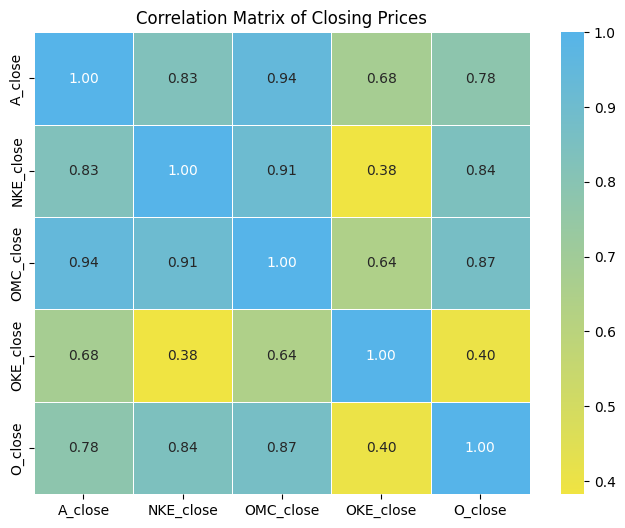

In [ ]:
# Correlation Analysis including only close prices with Yellow and Sky Blue Colors
def plot_correlation_matrix_close(data, stocks):
    combined_data = pd.DataFrame()  # Initialize an empty DataFrame to hold the combined data

    # Collect close prices for each stock
    for stock_name in stocks:
        # Filter the data for the current stock and select only the 'close' column
        # Rename the column to include the stock name for distinction
        stock_data = data[data['symbol'] == stock_name][['close']].rename(
            columns={'close': f'{stock_name}_close'})

        # Concatenate the stock data to the combined_data DataFrame along the columns (axis=1)
        combined_data = pd.concat([combined_data, stock_data], axis=1)

    # Calculate the correlation matrix for the combined data
    correlation_matrix = combined_data.corr()

    # Create a custom colormap from Yellow to Sky Blue
    custom_cmap = LinearSegmentedColormap.from_list("YellowSkyBlue", ['#F0E442', '#56B4E9'])

    # Plot heatmap
    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt='.2f', linewidths=0.5)  # Create a heatmap with annotations using the custom colormap
    plt.title('Correlation Matrix of Closing Prices')  # Set the title of the heatmap
    plt.show()  # Display the plot

# Execute the function with the dataset and top 5 stocks
plot_correlation_matrix_close(prices_split_adjusted, top_5_stocks)


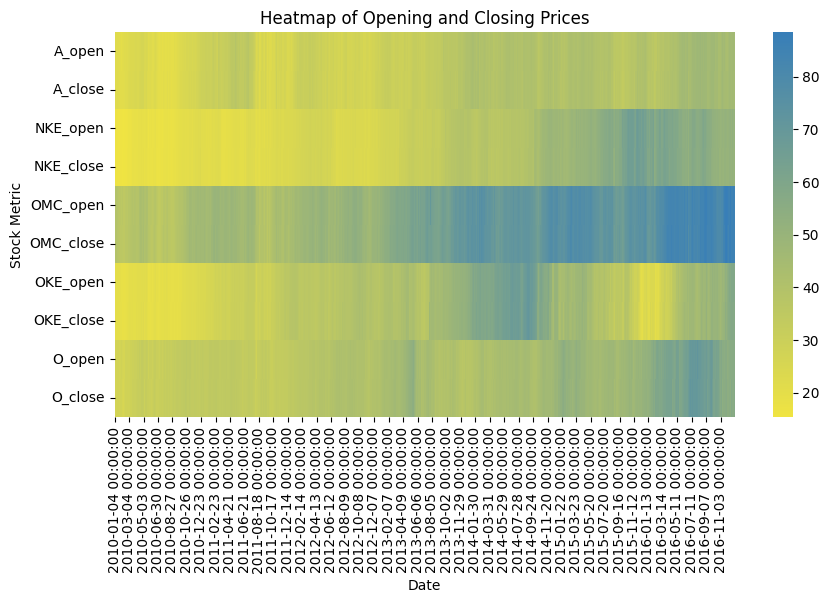

In [ ]:
# Heatmap of Opening and Closing Prices with Yellow and Dark Blue Colors
def plot_open_close_prices_heatmap(data, stocks):
    combined_data = pd.DataFrame()  # Initialize an empty DataFrame to hold the combined data

    # Loop over each stock symbol
    for stock_name in stocks:
        stock_open = data[data['symbol'] == stock_name]['open'].rename(f'{stock_name}_open')  # Extract and rename 'open' prices
        stock_close = data[data['symbol'] == stock_name]['close'].rename(f'{stock_name}_close')  # Extract and rename 'close' prices
        combined_data = pd.concat([combined_data, stock_open, stock_close], axis=1)  # Concatenate open and close prices

    # Create a custom colormap from Yellow to Dark Blue
    custom_cmap = LinearSegmentedColormap.from_list("YellowDarkBlue", ['#F0E442', '#377EB8'])

    plt.figure(figsize=(10, 5))  # Create a figure with the specified size
    sns.heatmap(combined_data.T, cmap=custom_cmap, cbar=True)  # Plot a heatmap with the custom colormap
    plt.title('Heatmap of Opening and Closing Prices')  # Set the title of the heatmap
    plt.xlabel('Date')  # Set the x-axis label
    plt.ylabel('Stock Metric')  # Set the y-axis label
    plt.show()  # Display the plot

# Execute the function with the dataset and top 5 stocks
plot_open_close_prices_heatmap(prices_split_adjusted, top_5_stocks)


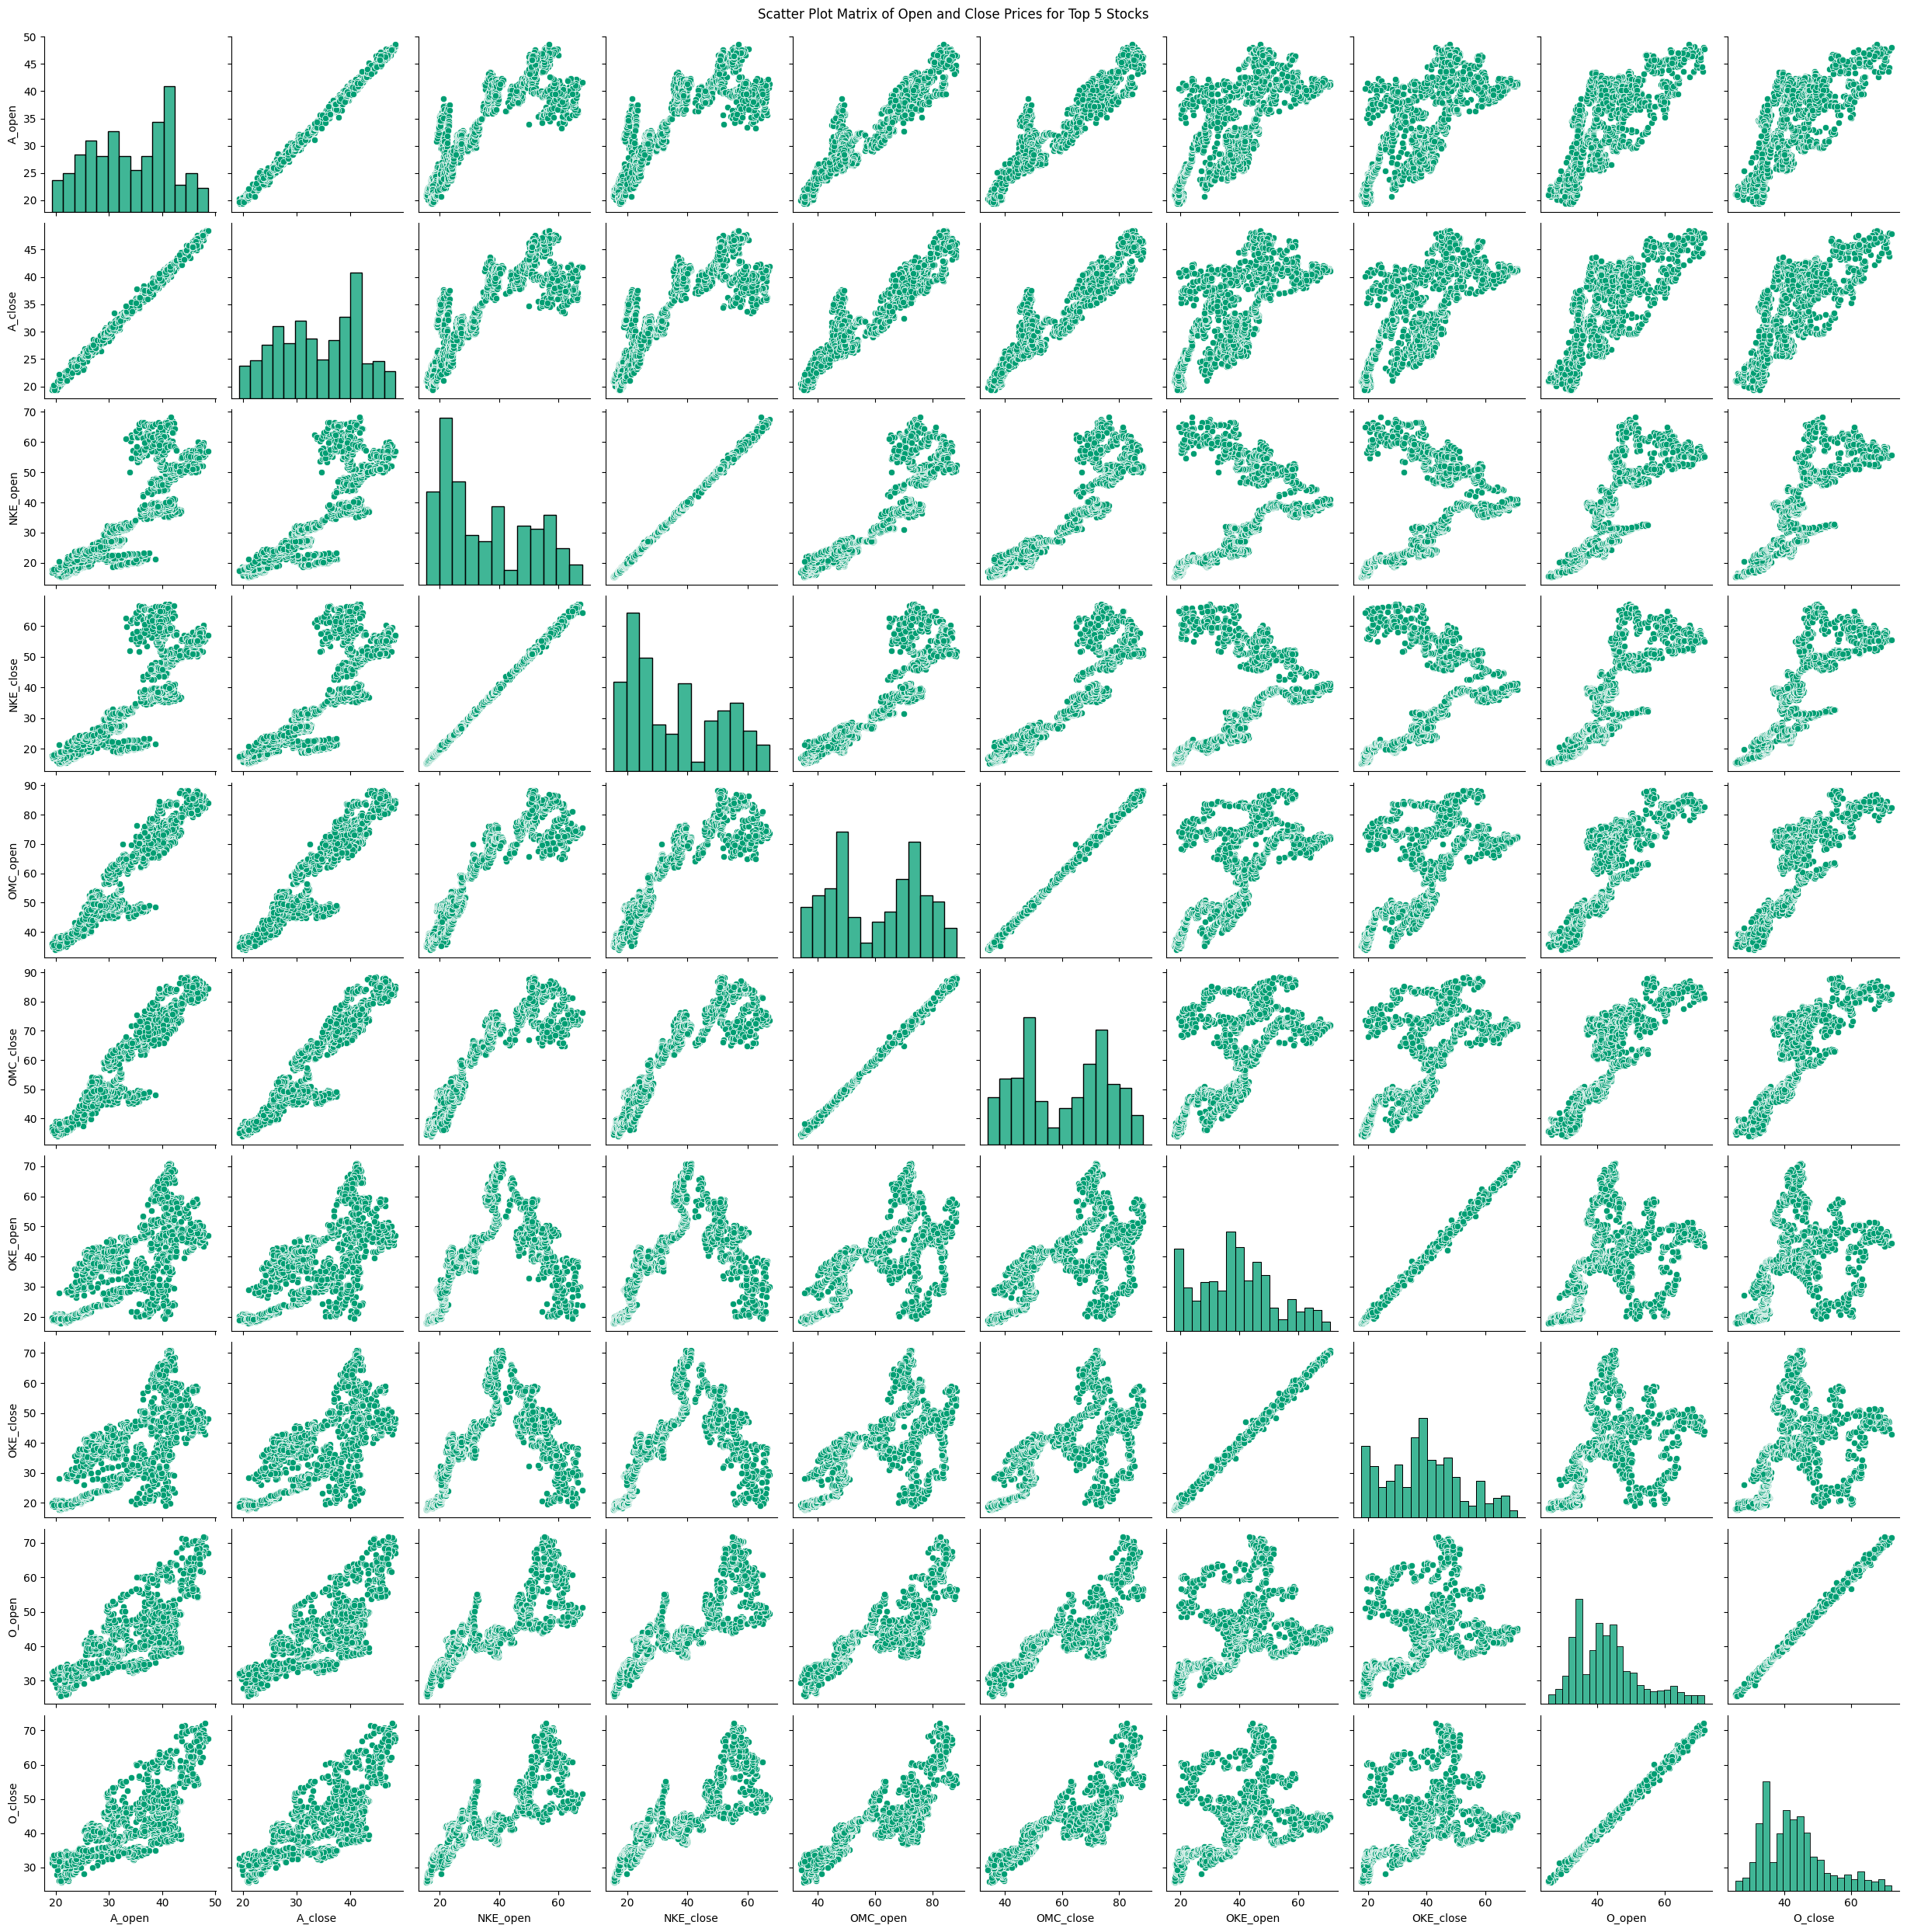

In [ ]:
# Scatter Plot Matrix for Open and Close Prices with Custom Color Palette
def plot_scatter_matrix(data, stocks):
    combined_data = pd.DataFrame()  # Initialize an empty DataFrame to hold the combined data

    # Loop over each stock symbol
    for stock_name in stocks:
        # Extract 'open' and 'close' prices for the current stock and rename the columns
        stock_data = data[data['symbol'] == stock_name][['open', 'close']].rename(
            columns={'open': f'{stock_name}_open', 'close': f'{stock_name}_close'})

        # Concatenate the open and close prices for the current stock to the combined_data DataFrame along the columns (axis=1)
        combined_data = pd.concat([combined_data, stock_data], axis=1)

    # Set a custom color palette (light green)
    custom_palette = sns.color_palette(["#009E73"])

    # Apply the custom color palette
    sns.set_palette(custom_palette)

    # Plot scatter plot matrix with the custom color palette
    sns.pairplot(combined_data)  # Create a scatter plot matrix of the combined data
    plt.suptitle('Scatter Plot Matrix of Open and Close Prices for Top 5 Stocks', y=1.00)  # Set the title of the plot
    plt.show()  # Display the plot

# Execute the function with the dataset and top 5 stocks
plot_scatter_matrix(prices_split_adjusted, top_5_stocks)
